<a href="https://colab.research.google.com/github/agroimpacts/VegMapper/blob/dev-calval-simplify/process_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a single training/validation/test set from multiple Collect Earth projects



### Table of Contents

* [Overview](#overview)
* [Set-up](#setup)
* [Sample preparation](#sample-prep)
    * [Read-in, reshape, and recode](#reshape-recode)
    * [Simplify the classes](#simplify)
    * [Calculate sample agreement](#agreement)
* [Split the dataset](#split)
    * [Combine and convert to spatial](#combine)

## Overview <a class="anchor" id="overview"></a>
This notebook demonstrates how several Collect Earth Online projects can be:

1. Provide functionality to check the structure and validity of user input for modeling; Yet, users are responsible for providing data in good format.
2. Re-code the class values and rename the column names.
2. Merged into a single dataset that provide a single label for each sample point and an estimate of label uncertainty;
3. Split into training, validation, and test (or map reference) samples.

The data used in this demonstration are the results of three Collect Earth Online projects that were captured over the Department of Ucayali, Peru. Each project represents the efforts of an individual (or group of individuals working in the same project) to label 1350 points, classifying each into 1 of 4 classes: not oil palm; young oil palm; mature oil palm;  unsure. The datasets preserve all the information from these projects, although user email addresses were anonymized.

## Sample preparation <a class="anchor" id="sample-prep"></a>
Load packages, setup configuations, define a helper function...

In [1]:
# from label_utils import load_csv, subset_cols, rename_cols,\
#     check_exclusive, recode, combine_labelers, get_mode_and_occurence

#@title (RUN) Setup code
## Mount Drive
from google.colab import drive
root = '/content/gdrive'
drive.mount(root)

## Clone and/or update VegMapper
import os
# from datetime import datetime as dt
import pandas as pd
from sklearn.model_selection import train_test_split

repo_path = f"{root}/MyDrive/repos"
clone_path = 'https://github.com/agroimpacts/VegMapper.git'
if not os.path.exists(repo_path):
    print(f"Making {repo_path}")
    os.makedirs(repo_path, exist_ok=True)

if not os.path.exists(f"{repo_path}/VegMapper"):
    !git -C "{repo_path}" clone "{clone_path}"
else:
    !git -C "{repo_path}/VegMapper" pull

os.chdir(f"{repo_path}/VegMapper")

# Import sample_utils function
from vegmapper.calval.label_utils import *
from functools import partial

Mounted at /content/gdrive
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 141.19 KiB | 72.00 KiB/s, done.
From https://github.com/agroimpacts/VegMapper
   ea8d0ba..d986703  dev-calval-simplify -> origin/dev-calval-simplify
Updating c434ee4..d986703
error: Your local changes to the following files would be overwritten by merge:
	vegmapper/calval/label_utils.py
	vegmapper/calval/sample_utils.py
Please commit your changes or stash them before you merge.
Aborting


In [14]:
# @title Loading CSVs

while True:
    try:
        num_users = int(input("Enter the number of CEO projects (The number of CEO projects must be more than 2): "))
        if num_users < 2:
            print("The number of CEO projects must be at least 2.")
        else:
            break
    except ValueError:
        print("Invalid input. Please enter a valid number.")

# Initialize the list to store file paths
fs = []

# Loop to input file paths for each user
for i in range(num_users):
    while True:
        file_path = os.path.join("./calval/data/", input(f"Enter the CSV file name for user {i+1}: "))
        if not file_path:
            print("File name cannot be empty.")
        else:
            fs.append(file_path)
            break

Enter the number of CEO projects (The number of CEO projects must be more than 2): 2
Enter the CSV file name for user 1: ceo-survey-user1.csv
Enter the CSV file name for user 2: ceo-survey-user2.csv


In [3]:
# @title Defining columns
# Initialize the new_col_name variable as an empty list
new_col_names = []

# Hardcoded column renames
rename_dict = {
    "plot_id": "Point_ID",
    "pl_cluster": "Clust",
    "center_lat": "Lat",
    "center_lon": "Lon"
}

# Get user input for additional column renames
num_additional_columns = int(input("Enter the number of additional columns to rename: "))
for i in range(num_additional_columns):
    old_column = input(f"Enter the old column name for additional column {i + 1}: ")
    new_column = input(f"Enter the new column name for additional column {i + 1}: ")
    rename_dict[old_column] = new_column
    new_col_names.append(new_column)

print("Updated rename_dict:")
print(rename_dict)
print("new_col_name:")
print(new_col_names)


Enter the number of additional columns to rename: 3
Enter the old column name for additional column 1: Oil Palm?:Mature Oil Palm
Enter the new column name for additional column 1: y
Enter the old column name for additional column 2: Oil Palm?:Not Oil Palm
Enter the new column name for additional column 2: n
Enter the old column name for additional column 3: Oil Palm?:Not Sure
Enter the new column name for additional column 3: unsure
Updated rename_dict:
{'plot_id': 'Point_ID', 'pl_cluster': 'Clust', 'center_lat': 'Lat', 'center_lon': 'Lon', 'Oil Palm?:Mature Oil Palm': 'y', 'Oil Palm?:Not Oil Palm': 'n', 'Oil Palm?:Not Sure': 'unsure'}
new_col_name:
['y', 'n', 'unsure']


In [13]:
# @title Defining which columns represents presence (1), absence (0) or unsure (2)

recode_dict = {}

# Iterate through new_col_names and get user input for values
for column_name in new_col_names:
    arbitrary_number = int(input(f"Enter a number for the'{column_name}' category: "))
    recode_dict[column_name] = arbitrary_number

print("Updated recode_dict:")
print(recode_dict)

Enter a number for the'y' category: 1
Enter a number for the'n' category: 0
Enter a number for the'unsure' category: 2
Updated recode_dict:
{'y': 1, 'n': 0, 'unsure': 2}


### Read-in, reshape, and recode classes <a class="anchor" id="reshape-recode"></a>
The first step was to combine the three datasets into a single dataset, with the columns from each of the three CEO projects, and to recode the four classes into a single column with values 0 (absence),  1 (presence), and 2 (unsure). At this step, we end up with 3 columns, 1 per completed CEO project: `cl1` = samples from project 1, `cl2` = samples from project 2, `cl3` = samples from project 3. Each column contains the recoded classes (note the renaming of the columns is done in the next code chunk).

In [5]:
# @title Process and combine csvs
def process_csv(csv_path, rename_dict, recode_dict):

    """
    A csv processing pipeline. This function takes a single csv file
    and let it pass through a sequence of our pre-defined functions
    return: a pandas dataframe of the processed csv.
    """
    print("processing: {}".format(csv_path))
    df = load_csv(csv_path)
    df = rename_cols(df, rename_dict)
    check_exclusive(df, csv_path, new_col_names)

    # if you want to combine Young and Mature, just recode both to be 1.
    df = recode(df, recode_dict, label_name, new_col_names)

    df = subset_cols(df, [*key_col,  *useful_col, label_name])

    return df

# Set columns to keep:
# key_col and label_name are used for joining users's datasets,
# columns in useful_col will not participate in joining
# and come from the first user instead to avoid repetition.
key_col = ["Point_ID", "Clust"]
label_name = "labeler"
useful_col = ["Lat", "Lon"]

#Set random seed for train/validation/reference split
seed = 999

# Define a partial function with fixed arguments
process_csv_partial = partial(process_csv, rename_dict=rename_dict, recode_dict=recode_dict)

# Process ceo-survey-users one by one
dats = list(map(process_csv_partial, fs))

# Combine three datasets into one
combined = combine_labelers(dats, by=["Point_ID", "Clust"], label_name=label_name)
combined.head()

processing: ./calval/data/ceo-survey-user1.csv
processing: ./calval/data/ceo-survey-user2.csv


/content/gdrive/MyDrive/repos/VegMapper/vegmapper/calval/label_utils.py:111: UserWarning: Found at least one entry(s) that does not have mutually exclusive labels.
        >>>file: ./calval/data/ceo-survey-user1.csv<<<
        Check your columns values.
        (1)Make sure no empty entry in those columns.
        (2)Make sure there is one and only one column is labeled as 100.
  warnings.warn('Found at least one entry(s) that does not have mutually exclusive labels.\n\
/content/gdrive/MyDrive/repos/VegMapper/vegmapper/calval/label_utils.py:111: UserWarning: Found at least one entry(s) that does not have mutually exclusive labels.
        >>>file: ./calval/data/ceo-survey-user2.csv<<<
        Check your columns values.
        (1)Make sure no empty entry in those columns.
        (2)Make sure there is one and only one column is labeled as 100.
  warnings.warn('Found at least one entry(s) that does not have mutually exclusive labels.\n\


,Point_ID,Clust,Lat,Lon,labeler_1,labeler_2
0,140884433,1,-8.321900,-75.045545,1,1
1,140884434,1,-8.344409,-74.884792,0,0
2,140884435,0,-8.836094,-74.342566,0,0
3,140884436,1,-8.321630,-75.031377,1,1
4,140884437,0,-10.948943,-71.736808,0,0


### Simplify the classes <a class="anchor" id="simplify"></a>

In this step, a single classification is created by finding the modal class for each sample point across the 3 groups' results. This creates a new `class` column, which provides the class from the majority opinion.

We repeat this same step again after first collapsing, within each of the `cl1:cl3` columns, the two oil palm classes into a single *oil palm* class with value = 1--*not oil palm* remains 0, and *unsure* remains 3. The modal function was re-run to create a new consensus class, called `class2`. We recommend that `class2` be used for modelling, while `class` may be useful for understanding error patterns.

### Calculate sample agreement <a class="anchor" id="agreement"></a>
The next step was to calculate some agreement metrics across the three groups' samples. The primary approach was to calculate the proportion of labelling teams that selected the modal class. Since there were just three teams in this example, values were either 0.333, 0.667, 1. This agreement was calculated across for both the original classification scheme (class: 0-3) and the simplifed scheme (), with columns `agree` and `agree2` providing the respective proportions for each observation.

In [10]:
# @title Agreemnt mode
num_labelers = int(input("Enter the number of labelers: "))

labels = []

for i in range(1, num_labelers + 1):
    label = f"labeler_{i}"
    labels.append(label)

combined[['mode', 'mode_agreement']] = combined[labels].apply(get_mode_and_occurence, axis=1, result_type='expand')
pd.set_option('display.max_rows', None)
#print(combined)

# we can set the mode to -9999 if there is no agreement (mode_freq = 1/num_labelers)
combined.loc[combined['mode_agreement'] <= 1/3, 'mode'] = -9999

combined = combined.drop(combined[combined['mode'] == -9999].index)
print(combined.shape)

combined.head()

Enter the number of labelers: 2
(1350, 8)


,Point_ID,Clust,Lat,Lon,labeler_1,labeler_2,mode,mode_agreement
0,140884433,1,-8.321900,-75.045545,1,1,1.0,1.0
1,140884434,1,-8.344409,-74.884792,0,0,0.0,1.0
2,140884435,0,-8.836094,-74.342566,0,0,0.0,1.0
3,140884436,1,-8.321630,-75.031377,1,1,1.0,1.0
4,140884437,0,-10.948943,-71.736808,0,0,0.0,1.0


We can then calculate the average agreement per sample to get a sense of the uncertainty in labels for each class, for all 4 classes

In [ ]:
# @title Average agreement per sample
agreement = combined.groupby("mode").mean()
agreement = agreement.rename(columns={"mode_agreement": "mean agreement"})
print(agreement[['mean agreement']])

      mean agreement
mode                
0.0         0.988607
1.0         0.894253
2.0         0.690476


In [ ]:
# @title Check the result
combined.head()

,Point_ID,Clust,Lat,Lon,labeler_1,labeler_2,labeler_3,mode,mode_agreement
0,140884433,1,-8.321900,-75.045545,1,1,1,1.0,1.0
1,140884434,1,-8.344409,-74.884792,0,0,0,0.0,1.0
2,140884435,0,-8.836094,-74.342566,0,0,0,0.0,1.0
3,140884436,1,-8.321630,-75.031377,1,1,1,1.0,1.0
4,140884437,0,-10.948943,-71.736808,0,0,0,0.0,1.0


And for the reduced set of classes

## Split the dataset <a class="anchor" id="split"></a>

Here we split the dataset into three parts for model training (60% of the sample), validation (20%), and final assessment (the 20% set aside as the test or map reference dataset).

The splits are confined to the usable sample, which is defined as samples not falling into class 3 and those with at least 2/3 observers agreeing on the class. This decision is made based on the simplified sample scheme (class2), rather than the full scheme (class). The resulting splits are denoted in a column called `usage` (this is distinct from the column `use`, which was used to filter out unusable observations).

Values of "unusable" in the `usage` column indicate observations that were not usable because of their low agreement or uncertain class.  They are included here for completeness, and in case they help with evaluation


In [ ]:
# @title Split the dataset
train, test = train_test_split(combined, test_size=0.4, train_size=0.6,
                               random_state=seed)

val, ref = train_test_split(test, test_size=0.5, train_size=0.5,
                            random_state=seed)

out = pd.concat(
    [train.assign(usage="train"), val.assign(usage="validate"),
     ref.assign(usage="map_reference/test")]
).reset_index(drop=True)
out.head()

,Point_ID,Clust,Lat,Lon,labeler_1,labeler_2,labeler_3,mode,mode_agreement,usage
0,140884459,0,-10.661994,-71.784007,0,0,0,0.0,1.000000,train
1,140884500,0,-9.320213,-73.921025,0,0,0,0.0,1.000000,train
2,140884488,1,-8.493207,-74.608635,0,0,0,0.0,1.000000,train
3,140885706,1,-8.263247,-74.816985,0,0,0,0.0,1.000000,train
4,140884597,1,-8.517548,-74.931080,2,2,1,2.0,0.666667,train


### Combine and export to csv <a class="anchor" id="combine"></a>

The ineligible portion of the sample is also added back for completeness

In [ ]:
#@title (RUN) Export sample
gdrive_folder = input(f"Enter the name of the output folder: \n\n")
csv_name = input(f"Enter the name of the output csv file: \n\n")

outpath = f"{root}/MyDrive/{gdrive_folder}/{csv_name}"
with open(outpath, 'w') as f:
    out.to_csv(f, float_format='{:f}'.format, encoding='utf-8',
                    index=False)

print('file exported')

Enter the name of the output folder: 

test
Enter the name of the output csv file: 

test
file exported


And their locations on a map

[1 2 3]


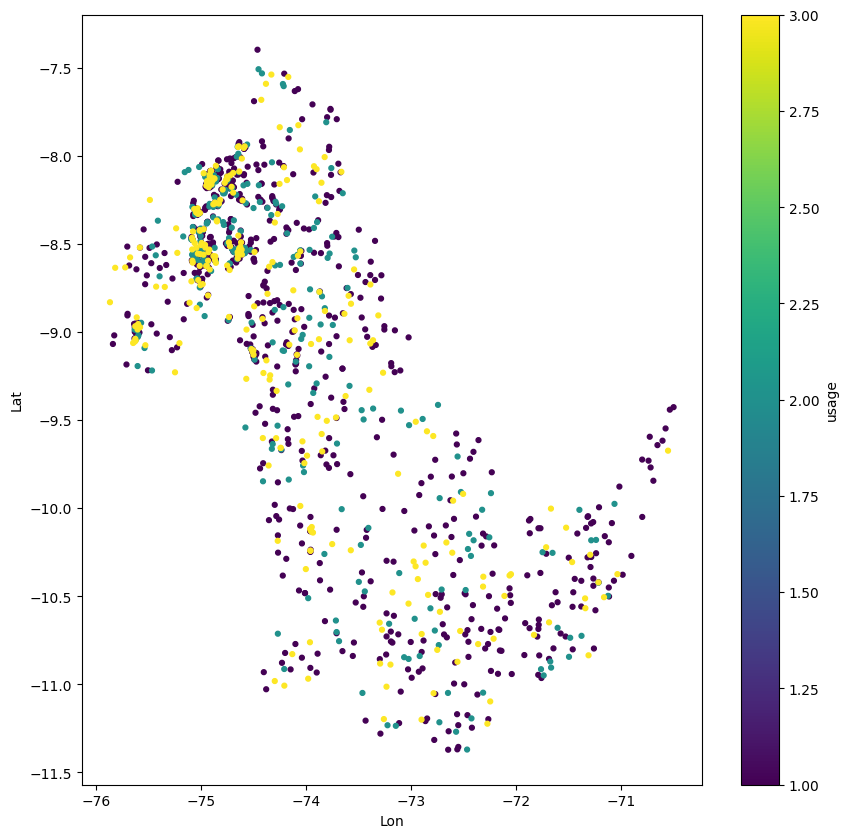

In [ ]:
# @title Plot samples
plot_sample = out.copy()

usage_dict = {'train': 1, 'validate': 2, "map_reference/test": 3, "unusable": 4}
plot_sample = plot_sample.replace({'usage': usage_dict})

print(plot_sample['usage'].unique())

rcParams['figure.figsize'] = 10, 10
plot_sample.plot.scatter(x='Lon', y='Lat', c='usage', s=12, cmap='viridis')
None